# Reconstruction with Phase Fitting

Good resource on digital holographic microscopy: [Ulf Schnars and Werner P O Juptner, Meas. Sci. Technol. 13 (2002) R85–R101](http://x-ray.ucsd.edu/mediawiki/images/d/df/Digital_recording_numerical_reconstruction.pdf)

On phase mask adjustment: [Colomb et al; Appl Opt. 2006 Feb 10;45(5):851-63.](http://www.ncbi.nlm.nih.gov/pubmed/16512526)

In [115]:
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters

def peakshift(arr, shifts):
    '''
    Take 2D array `arr` and roll the contents in 
    two dimensions, with shifts set by the elements
    of `shifts` for the (x,y) directions.
    
    Parameters
    ----------
    arr : `N x M` dim array
        Array to roll
    shifts : list of length `M`
        Desired shifts in x, y directions
    '''
    return np.roll(np.roll(arr, shifts[0], axis=0), 
                   shifts[1], axis=1)

def apodize(arr):
    '''
    Force the magnitude at the boundaries go to zero
    '''
    N = np.shape(arr)[0]
    y, x = np.mgrid[0:N, 0:N]
    xmask = np.cos((x-N/2.)*np.pi/N)**0.25
    ymask = np.cos((y-N/2.)*np.pi/N)**0.25
    return arr*xmask*ymask

def calc_mask(N, centerx=285, centery=200, radius=250):
    '''
    Calculate the Fourier-space mask to isolate the real image
    
    Parameters
    ----------
    N : int
        Dimension of image
    centerx : int
        y centroid of real image in Fourier space
    centery : int
        x centroid of real image in Fourier space
    radius : float
        Radial width of mask
    '''
    y, x = np.mgrid[0:N, 0:N]
    mask = np.zeros((N, N))
    mask[(x-centerx)**2 + (y-centery)**2 < radius**2] = 1.0
    return mask

def calc_G(d, N, wavelength=405e-9, dx=3.45e-6, dy=3.45e-6):
    '''
    Calculate the Fourier transform of impulse response function,
    for reconstruction at distance `d`
    '''
    y, x = np.mgrid[0:N, 0:N] - N/2
    A = wavelength**2*(x+N**2*dx**2/(2.0*d*wavelength))**2/(N**2*dx**2)
    B = wavelength**2*(y+N**2*dy**2/(2.0*d*wavelength))**2/(N**2*dy**2)
    G = np.exp(-1j*2.0*np.pi*d/wavelength*np.sqrt(1.0-A-B))
    return G

def calc_R(Psi, wavelength=405e-9, r=[870, 140], c=[140, 870],
          m=100, dx=3.45e-6, dy=3.45e-6, plots=False):
    '''
    Calculate the reference wave.
    
    Parameters
    ----------
    Psi : arr
        The product of the Fourier transform of the 
        hologram and the Fourier transform of impulse 
        response function
    r : list
        Rows in the reconstructed image where the 
        specimen is not
    c : list
        Columns in the reconstructed image where
        the specimen is not
    m : int
        Margin from edges of detector to avoid
    dx : float
        Pixel size in x, [m]
    dy : float
        Pixel size in y, [m]
    plots : bool
        Display plots after calculation?
    '''
    # m = margin for phase fitting
    N = np.shape(Psi)[0]
    order = 3
    OPD = wavelength / (2*np.pi)
    y, x = np.mgrid[0:N, 0:N] - N/2
    pixvec = x[0, m:-m]
    img2 = np.fft.ifft2(Psi)
    img2 = peakshift(img2, [N/2, N/2])
    pimg2 = np.arctan(np.imag(img2)/np.real(img2)); 

    px = np.unwrap(pimg2[r, m:-m,]*2.0)/2*OPD
    py = np.unwrap(pimg2[m:-m, c].T*2.0)/2*OPD
    px = np.mean(px, axis=0)
    py = np.mean(py, axis=0)

    pxpoly = np.polyfit(pixvec, px, order)
    pypoly = np.polyfit(pixvec, py, order)

    R = np.exp(-1j/OPD*(np.polyval(pxpoly, x) + np.polyval(pypoly, y)))
    if plots:
        fig, ax = plt.subplots(1,figsize=(15,8))
        ax.plot(pixvec, px/(wavelength/(2*np.pi)))
        ax.plot(pixvec, np.polyval(pxpoly, pixvec)/OPD, 'r--')

        plt.figure()
        plt.imshow(np.arctan(np.imag(R)/np.real(R)))#, origin='lower')
        plt.title('Fitted phase mask')
        plt.show()
    return R

def calc_centroid(Farr, margin=50):
    '''
    Calculate the centroid of the pixel spike
    
    Parameters
    ----------
    Farr : array
        Fourier transformed hologram
    margin : int
        Avoid the nearest `margin` pixels from the edge
        of detector
    '''
    N = np.shape(Farr)[0]
    absFarr = filters.gaussian_filter(
        np.abs(Farr)[margin:N/2, margin:N/2],10)
    spectrum_centroid = np.array(np.unravel_index(absFarr.T.argmax(),
                                 absFarr.shape)) + margin
    return spectrum_centroid 

def recon(inputfile, d, R=None):
    '''
    Reconstruct image from hologram stored in file `inputfile` 
    at propagation distance `d`
    
    Parameters
    ----------
    inputfile : str
        Path to hologram file, open with PIL
    d : float
        Propagation distance [m]
    R : arr or None
        If none, calculate the reference wave. If not None,
        use array as reference wave array.
    '''
    # Read input image
    hologram = np.array(Image.open(inputfile))

    N = np.shape(hologram)[0]
    apodized_hologram = apodize(hologram)
    
    # Isolate the real image in Fourier space, find spectral peak
    F_hologram = np.fft.fft2(apodized_hologram)
    spectrum_centroid = calc_centroid(F_hologram)
    
    # Create mask based on coords of spectral peak:
    mask = calc_mask(N, centerx=spectrum_centroid[0],
                    centery=spectrum_centroid[1])
    # Calculate Fourier transform of impulse response function
    G = calc_G(d, N)
    if R is None:
        # Center the spectral peak
        shifted_F_hologram = peakshift(F_hologram*mask, 
                                       [N/2-spectrum_centroid[1], 
                                        N/2-spectrum_centroid[0]])

        # Apodize the result
        Psi = apodize(shifted_F_hologram*G)
        # Calculate reference wave
        R = calc_R(Psi, plots=False)

    # Reconstruct the image
    Psi = G*peakshift(np.fft.fft2(apodized_hologram*R)*mask, 
                   [N/2 - spectrum_centroid[1], N/2 - spectrum_centroid[0]])
    reconstructed_image = peakshift(np.fft.ifft2(Psi), [N/2, N/2])
    return reconstructed_image, R

inputfile = '/Users/bmorris/SHAMU/emilio/Development/Hologram.tif'
reconstructed_image, reference_wave = recon(inputfile, 0.0369)

### Plot the reconstructed image

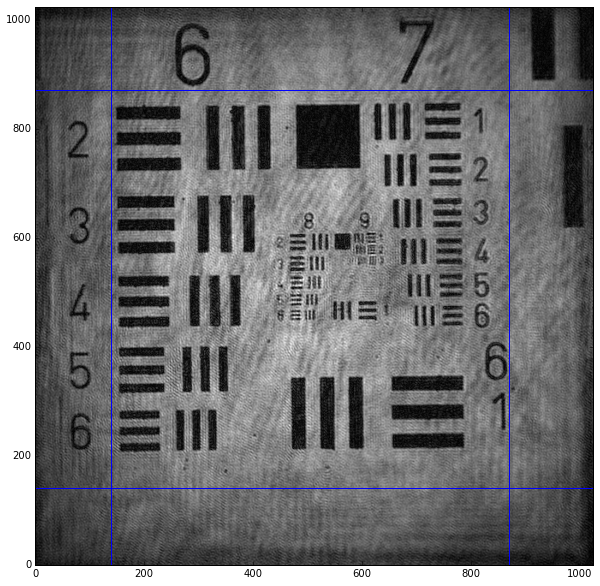

In [113]:
magimg2 = np.abs(reconstructed_image)
pimg2 = np.arctan(np.imag(reconstructed_image)/np.real(reconstructed_image))
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(magimg2[::-1,::-1], cmap=plt.cm.binary_r, origin='lower')

plt.axhline(870)
plt.axvline(140)
plt.axhline(140)
plt.axvline(870)
plt.show()

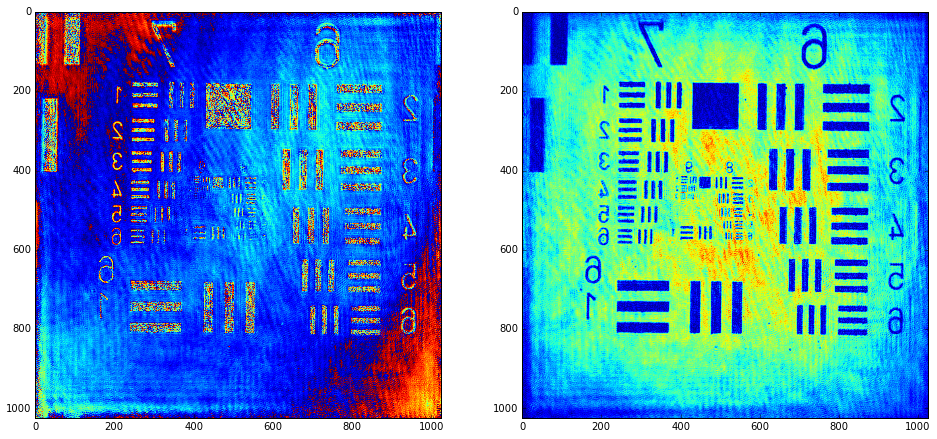

In [98]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(pimg2)
ax[1].imshow(np.abs(reconstructed_image))
plt.show()

### Going through focus to find it (visually)

In [99]:
import matplotlib.image as mimage

ds = np.linspace(0.035, 0.039, 10)
for d in ds:
    if d == ds[0]:
        reconstructed_image, R = recon(inputfile, d)    
    else:
        reconstructed_image, _ = recon(inputfile, d, R)
    mimage.imsave('outputs/{0:3.0f}.png'.format(d*1e4), np.abs(reconstructed_image))

### Speed with and without reference wave fitting

In [116]:
%timeit reconstructed_image, R = recon(inputfile, d)  
%timeit reconstructed_image, _ = recon(inputfile, d, R)

1 loops, best of 3: 2.71 s per loop
1 loops, best of 3: 1.32 s per loop
